In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import time

start = time.process_time()

In [2]:
# defining constants

alpha = 0.4 

sweeps = 20000 # the amount of times we update the M-H path (should change)
tau = 250 # imaginary time, need to change tau 
dtau = 1 # time step
eta = dtau
ntau = int(tau / dtau) # number of time steps 
hitsize = 0.1 # need to test

xlow = - 4 # min x value
xhigh = 4 # max x value
n_xbins = 100 # number of x steps
dx = (xhigh - xlow) / n_xbins # size of x step
x_bins = np.linspace(xlow, xhigh, n_xbins + 1) # x steps

x_path = np.zeros(ntau)

what tau_b do we need theoretically to arrive at ground state --
and tune delta tau 

beta = 1/(k_b)t  thermal energy 

we want to solve for the maxwells dist. 

want kbt to be significantly less than the ground state energy 


In [3]:
def potential(x):
    
    """
    Defining the potential at some point x
    x: the value at which to determine the potential
    Returns: the double well potential, at that point
    """
    return (alpha * x ** 4) - (2 * x ** 2) + (1 / alpha)

def vary_path(x_current, hitsize):
    
    """
    Picking a random point in the domain.
    x_current: the current point in the x-domain
    Returns: a new point, randomly picked
    """
    x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
    
    while x_prime > xhigh or x_prime < xlow:
        x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
        
    return x_prime

# here I defined the action based on the lagrangian in the final project. 
# this is the exponential portion of eq 3 and 4
def action(x_left, x_right):
    """
    Determining the action from a left and right point.
    x_left: the left limit of the action potential
    x_right: the right limit of the action potential
    Returns: the action
    """
    k = 0.5 * (((x_right - x_left)) ** 2) / dtau
    v = dtau * potential(((x_left + x_right) / 2))
    return k + v

# action S is the integral of the lagrangian. So that is why this can be K + V instead of K - V 
# not used as of right now
def total_action(x_path):
    """
    Determining the total action across some point.
    x_path: the path across which to determine the action
    Returns: the total action
    """
    path_action = 0
    
    for i in range(-1, n_xbins - 1):
        path_action += action(x_path[i], x_path[i + 1])
        
    return path_action

def delta_action(x_path, prime, i):
    """
    Determining the difference in action across some point and in comparison to another point.
    x_path: the path across which to determine the action
    prime: the other point to compare the action to
    i: the index of the point to compare actions across
    Returns: the total action
    """
    left = x_path[i - 1]
    right = x_path[i + 1] if i < ntau - 1 else x_path[0] 
    daction = action(left, prime) + action(prime, right) - (action(left, x_path[i]) + action(x_path[i], right))

    return daction

In [69]:
def mcmc(x_path, mean_energies, prob_histogram, n_accept, tau = 250, dtau = 1, hitsize = 0.1, thinning_val = 1): 
    """
    Applying MCMC algorithm to path to find ground state energy, proportional to x^2
    
    x_path: the path across which to apply the MCMC algorithm
    mean_energies: array to save energy values to
    prob_histogram: array to save probability values to
    n_accept: number of accepted values
    tau: imaginary time for algorithm to run across 
    dtau: step size for tau
    hitsize: random interval size to generate value from
    thinning_val: value used to consider for thinning the algorithm, default one
    
    Return: number of accepted values
    """
    ntau = int(tau / dtau)
    
    for i in range(0, ntau, thinning_val):
        
        x_prime = vary_path(x_path[i], hitsize)
        daction = delta_action(x_path, x_prime, i)
        
        if daction <= 0: 
            x_path[i] = x_prime
            n_accept += 1
            
        else:     
            prob = np.exp(- daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
                n_accept += 1
                
    mean_energies.append(np.mean([i ** 2 for i in x_path]))
    
    hist, _ = np.histogram(x_path, bins = x_bins)
    prob_histogram += hist
    return n_accept
    

In [73]:
# doing the mcmc for the number of sweeps (iterations)    

mean_energies = []
prob_histogram = np.zeros(n_xbins)
n_accept = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept = mcmc(x_path, mean_energies, prob_histogram, n_accept)

n_accept / (sweeps * ntau)

100%|████████████████████████████████████| 20000/20000 [01:25<00:00, 233.33it/s]


0.955537

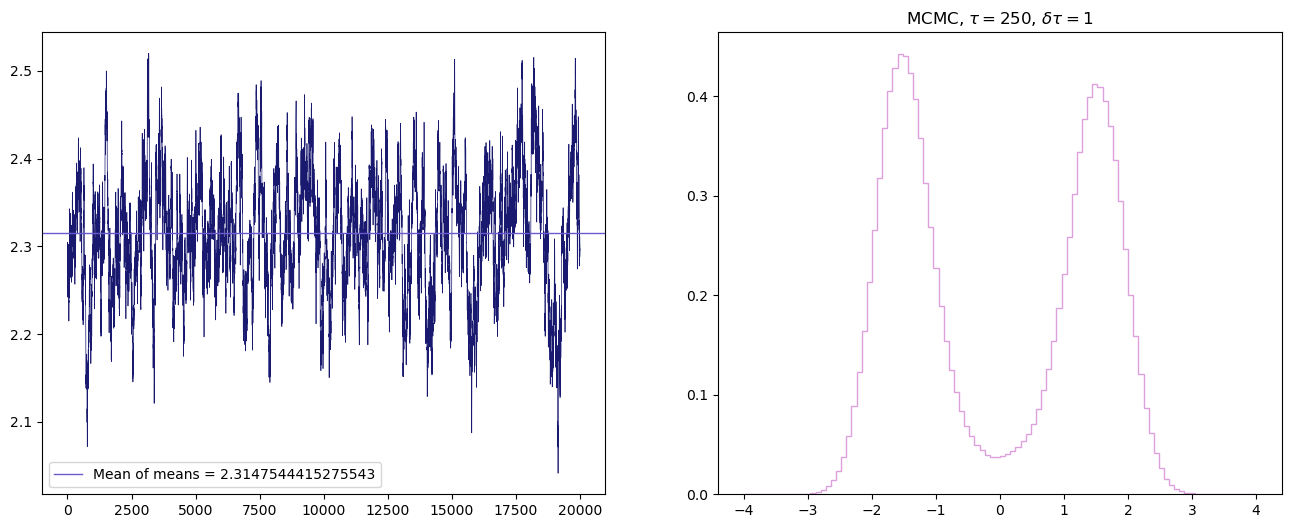

In [74]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies)), mean_energies, lw = 0.5, color = 'midnightblue')
ax[0].axhline(np.mean(mean_energies), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies)))
ax[0].legend()

ax[1].stairs(prob_histogram / np.sum(prob_histogram * dx), x_bins, color = 'plum')
ax[1].set_title(f"MCMC, $\\tau = {tau}$, $\delta\\tau= {dtau} $")

plt.show()

In [75]:
# previous iteration was with a cold setting
# now rerun and compare with hot, where the initial path is random

mean_energies_hot = []
prob_histogram_hot = np.zeros(n_xbins)
x_path_hot = np.array([np.random.random() for i in range(ntau)])
n_accept_hot = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_hot = mcmc(x_path_hot, mean_energies_hot, prob_histogram_hot, n_accept_hot)
    
mean_energies_cold = []
prob_histogram_cold = np.zeros(n_xbins)
x_path_cold = np.zeros(ntau)
n_accept_cold = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_cold = mcmc(x_path_cold, mean_energies_cold, prob_histogram_cold, n_accept_cold)
    

100%|████████████████████████████████████| 20000/20000 [01:20<00:00, 247.16it/s]


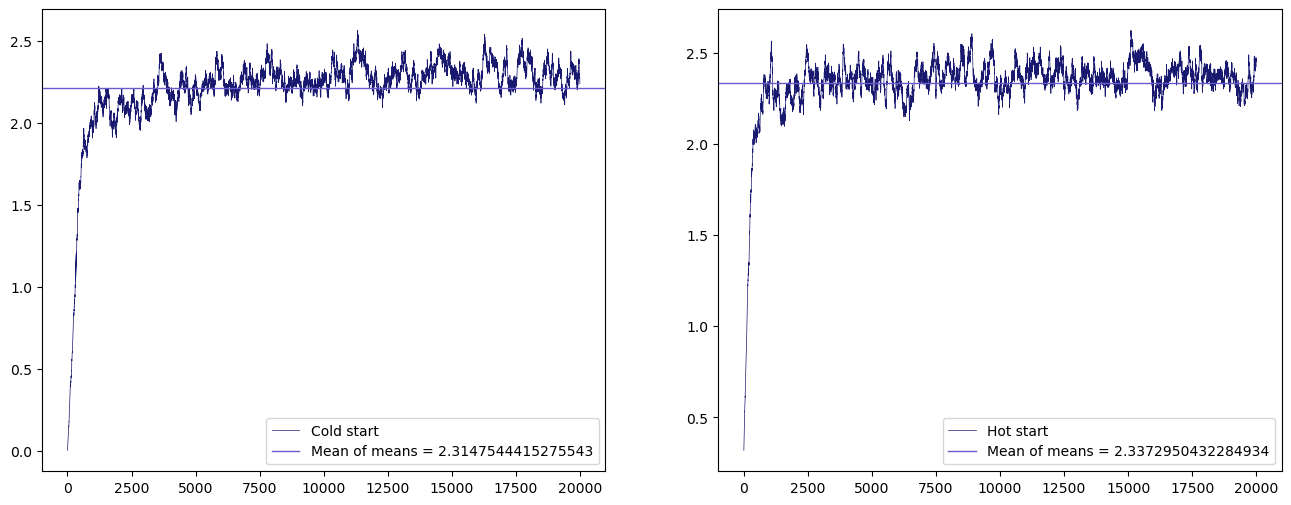

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_cold)), mean_energies_cold, lw = 0.5, color = 'midnightblue', label = 'Cold start')
ax[0].axhline(np.mean(mean_energies_cold), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies)))
ax[0].legend()

ax[1].plot(range(len(mean_energies_hot)), mean_energies_hot, lw = 0.5, color = 'midnightblue', label = 'Hot start')
ax[1].axhline(np.mean(mean_energies_hot), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_hot)))
ax[1].legend()

plt.show()

### Conclusion for hot vs cold test:

They are very similar. Hot seems to do marginally better, although not significantly.

Note that I only reran the above two cells like three times lol

Now I try to vary with variations in hitsize.

In [77]:
n_accept_hot / sweeps

how do i find. acceptance rate :/

238.6148

In [7]:
print((time.process_time() - start) / 60, 'minutes')

1.2802402666666666 minutes
